# Comparing rain gage data with radar data

Import the locally named Rain package containing all the tools for analysing rain gage networks. These tools are built on three different class objects: 

 - **`Rain`**: contains set of gage data or set of radar data at specified locations. 
 - **`RadarGage`**: merges a gage instance of **`Rain`** and a radar instance of **`Rain`** to facilitate comparisons
 - **`Event`**: contains data from specific times to facilitate mapping and other spatial analysis

In [1]:
%matplotlib inline
from rain import *

#### Charlotte:

Initialize the **`Rain`** object with a file containing all of the data or with a list of years. The output from this are all contained in attributed of the ** `Rain`** class. All of the data are contained in a **`pandas.DataFrame`** object called **`Rain.df`**

In [2]:
path = './input/CHARLOTTE/'

rg = Rain(path=path, name='Charlotte_CRN_gage_{YEAR}.csv', year=range(1993, 2016), ngages=71, freq='15min')
rad = Rain(path=path, name='Charlotte_CRN_radar_{YEAR}.csv', year=range(2001, 2016), ngages=71, freq='15min')
rg.ll_file = 'Charlotte_CRN_lat_lon.csv'
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()
p.save_path = './output/Charlotte/'

Check the following attributes carefully:
 
save_path = .
per_hour = 4
year = 1993-2015
units = mm
path = ./input/CHARLOTTE/
freq = 15min
ngages = 71
name = Charlotte_CRN_gage_2015.csv
Check the following attributes carefully:
 
save_path = .
per_hour = 4
year = 2001-2015
units = mm
path = ./input/CHARLOTTE/
freq = 15min
ngages = 71
name = Charlotte_CRN_radar_2015.csv


## Plot the relationship between radar and gage

/home/jsignell/miniconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


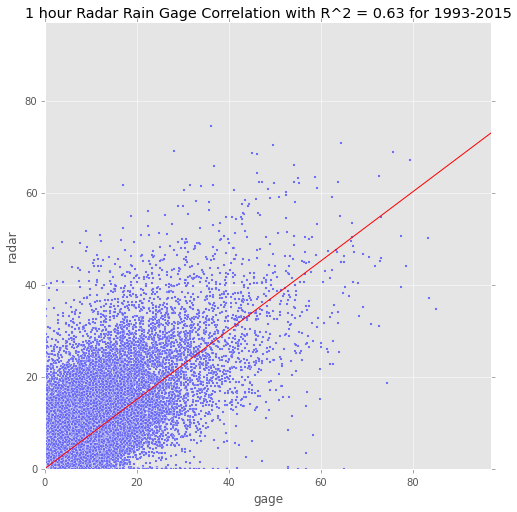

In [3]:
p.plot_correlation(time_step='1H')

If we are interested in the seasonal and diurnal patterns of rainfall, we can easily plot that up by running:

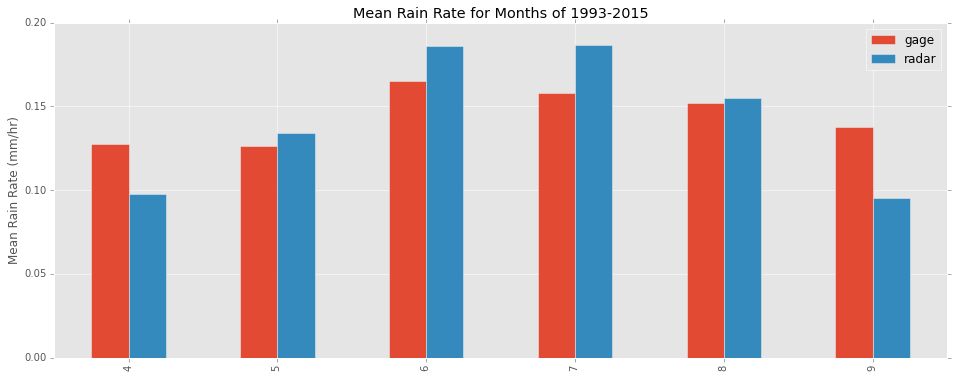

In [4]:
p.plot_rate(interval='seasonal')

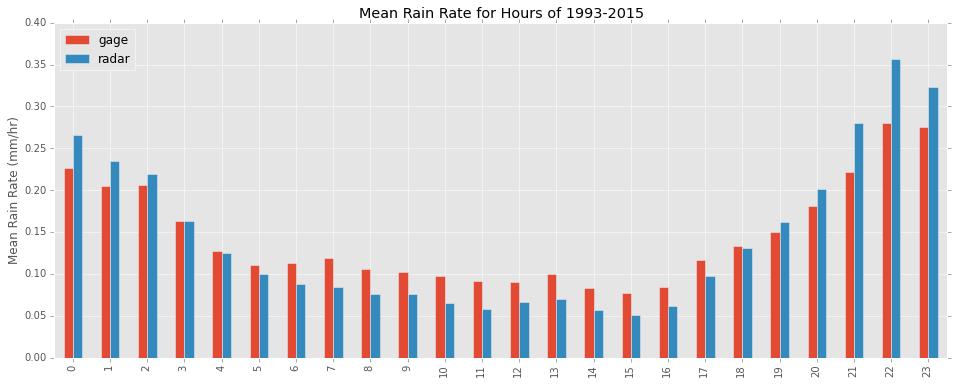

In [5]:
p.plot_rate(interval='diurnal')

## Plotting probability of wet days occuring

Say we want to determine which days are wet and which aren't based on threshold. The default threshold is the minimum non-zero value recorded over a timestep. The units on this are mm/hr.

Now we are ready to figure out which of the days are wet and which aren't. We can make a plot of the mean probability that a day will be wet using a variety of thresholds. In this instance we take the mean probability for each month.

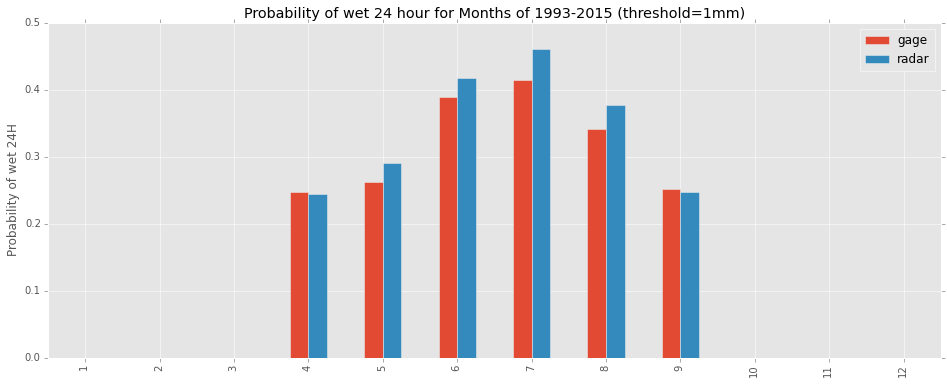

In [6]:
p.thresh = 1 * p.per_hour
p.plot_prob_wet(interval='seasonal', time_step='24H', base=12)

We can also make plots of the probability that different four hour intervals within the average day will be wet:

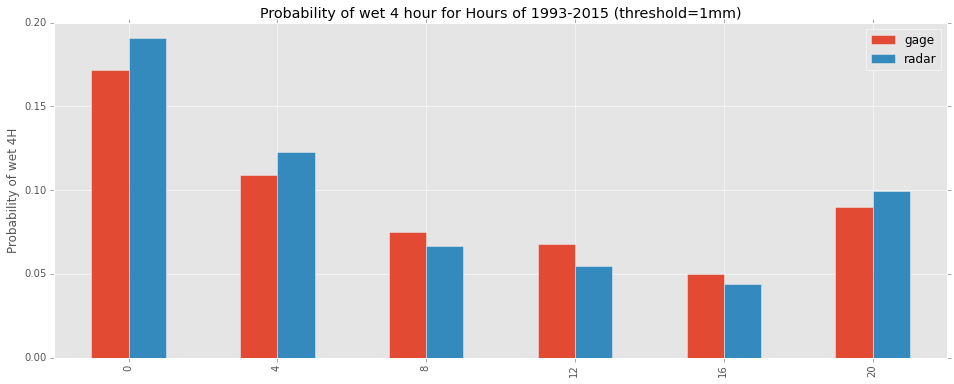

In [7]:
p.thresh = 1 * rg.per_hour
p.plot_prob_wet(interval='diurnal', time_step='4H')

## Mapping Rainfall

Once we are satisfied with the temporal components of the data, we are ready to try mapping the rain in space. As a first pass, we can just plot the mean rain rate at each location. The simplest way to create a may is by setting the keywords `gage=rg.list_gages()`, `bar=False` and `map=True`.

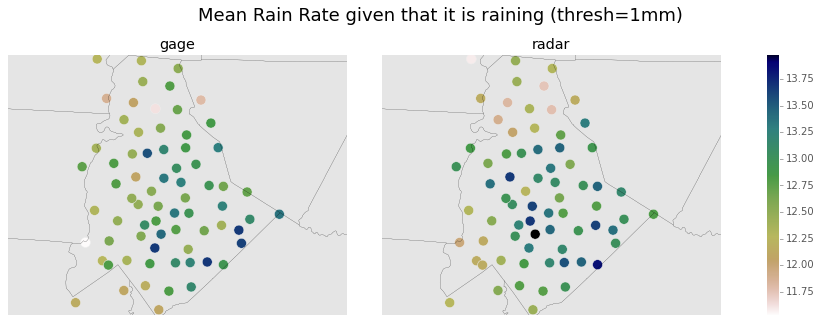

In [8]:
p.thresh = 1*p.per_hour
p.get_wet_rate()
Event(p.ll.join((p.wet_rate.mean(axis=1)))).map_rain(basemap=True, sharec=True, 
                                                     title='Mean Rain Rate given that it is raining (thresh=1mm)')

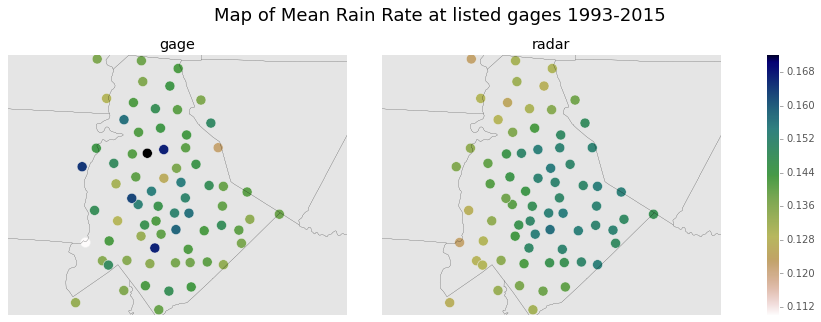

In [9]:
p.plot_rate(gage=p.list_gages(), bar=False, map=True, basemap=True, save=True, sharec=True)

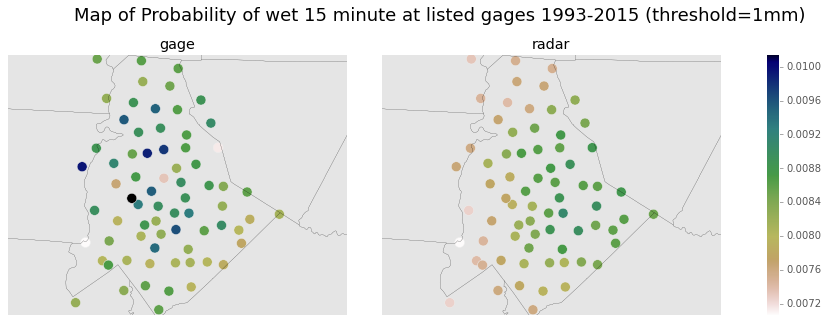

In [10]:
p.thresh = 1*p.per_hour
p.plot_prob_wet(gage=p.list_gages(), bar=False, map=True, basemap=True, save=True, sharec=True)

All of the other keywords that we were using before are still available, so we can set the `time_step` to whatever we want.

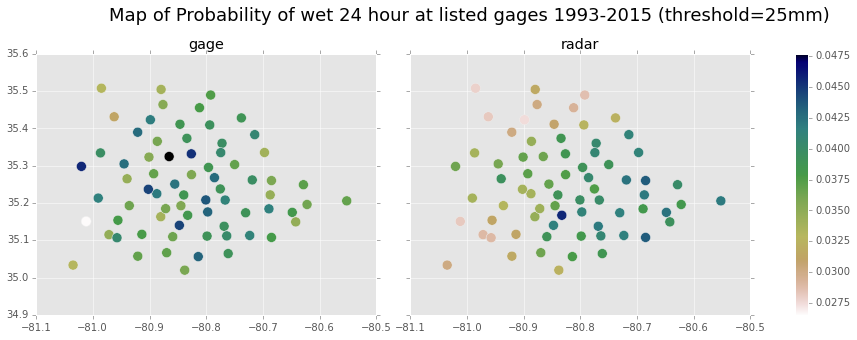

In [11]:
p.thresh = 25*p.per_hour
p.plot_prob_wet(time_step='24H', base=12, gage=p.list_gages(), bar=False, map=True, sharec=True)

For more complex uses, we will need to explicitly call the **`Event`** class. One example of this would be using lowess to find the time of peak rainfall within the average day. To accomplish this we will first get a dataframe of the max time using lowess. 

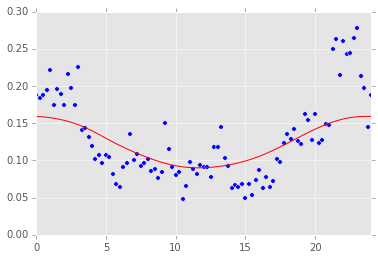

In [12]:
lmg = p.get_max_lowess(df=p.rate.gage)
lmg.columns = ['Gage lowess max']
lmr = p.get_max_lowess(df=p.rate.radar, example_plot=False)
lmr.columns = ['Radar lowess max']

We see in the plot an example of the fit being used. If we want it less smooth, we can change the f value from the default (.25) to any value between 0 and 1 that better suits us. Just be careful when using fractions to make the number a float (1/4**.** **not** 1/4). Once we are satisfied with the fit we can initiate an **`Event`** on a dataframe joining the lat/lon values of the **`Rain`** object with the lowess values. We can set a round color map using `cmap='hsv'`, and set the limits on the color values using `sharec=(min, max)`. To plot against latitude and longitude set `latlon=True`.

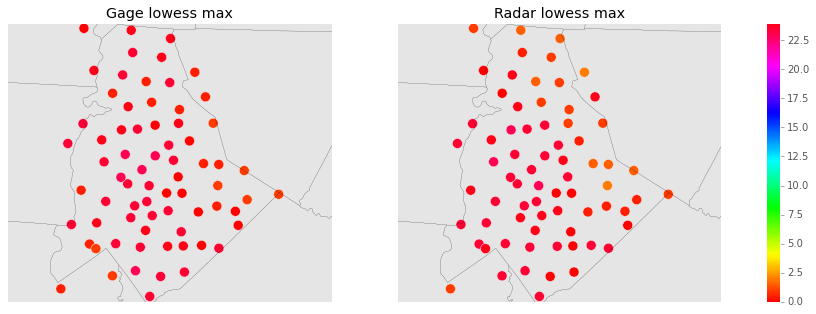

In [13]:
e = Event(p.ll.join((lmg,lmr)))
title = 'Map of Time of Peak Rainfall using lowess (f=.25) for 15min of {y}'
e.map_rain(latlon=True, cmap='hsv', sharec=(0,24), save_path=rg.save_path, 
           title=title.format(y=p.year), hide_title=True, basemap=True)

## Check out one particular storm

In [14]:
p.get_rainiest(5)
p.rainiest.head()

,lat,lon,RG,Y,X,Gage 2004-09-28 12:00:00,Radar 2004-09-28 12:00:00,Gage 2006-08-31 12:00:00,Radar 2006-08-31 12:00:00,Gage 2011-08-06 12:00:00,Radar 2011-08-06 12:00:00,Gage 2004-09-08 12:00:00,Radar 2004-09-08 12:00:00,Gage 2008-08-27 12:00:00,Radar 2008-08-27 12:00:00
RG,,,,,,,,,,,,,,,
RG1,35.302925,-80.749975,RG1,3903.585629,-7336.066789,5.495502,1.756833,1.634490,2.138917,3.661833,2.545208,4.828434,2.077250,8.799303,5.093268
RG2,35.331667,-80.826389,RG2,3906.763710,-7340.399641,4.387532,1.636125,2.172335,1.842000,4.751917,3.229875,5.215467,2.396625,7.478132,4.328146
RG3,35.275833,-80.826111,RG3,3900.589991,-7345.441484,4.086437,1.327000,1.624012,1.443000,6.720417,4.001917,6.129867,2.614167,6.773622,3.745561
RG4,35.192778,-80.935833,RG4,3891.406210,-7362.947874,0.000000,1.014167,2.376699,3.141708,2.529417,3.126875,3.118485,2.013625,6.206397,3.208049
RG5,35.278333,-80.892778,RG5,3900.866426,-7351.273203,2.344526,0.786458,1.548871,1.576167,5.979583,3.485833,3.860906,1.971625,7.150905,4.084976


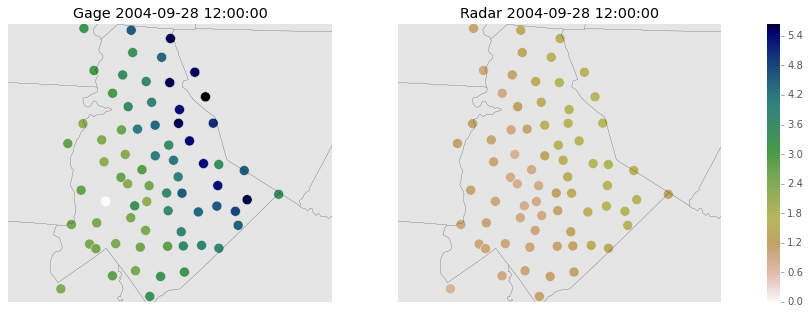

In [15]:
Event(p.rainiest[range(7)]).map_rain(sharec=True, hide_title=True, basemap=True)

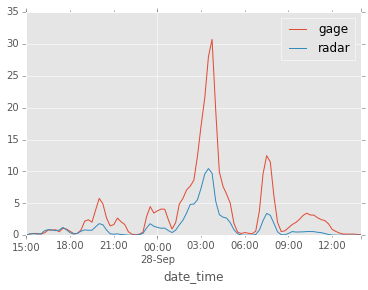

In [16]:
p.rate.mean(axis=2)['2004-09-27 15:00':'2004-09-28 14:00'].plot()
plt.show()

[using ordinary kriging]
[using ordinary kriging]


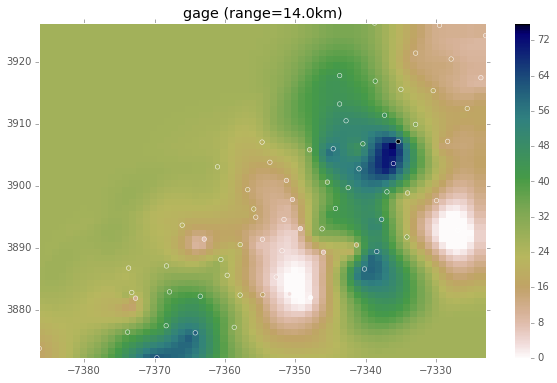

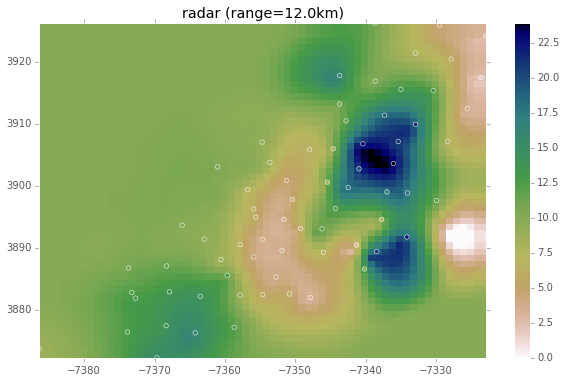

In [20]:
df = p.rate.loc[:,'2004-09-28 03:30',:]
e = Event(p.ll.join(df))

k = e.krige(i=5)
k = e.krige(i=6)